In [27]:
import numpy as np
from scipy import stats
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import os
import sys
import glob
import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import Image
import imageio
import pandas as pd
# ----------------------------------------------
# ######## En local ############
path_dir = os.getcwd()
from config.utils import *


print("TF version: ", tf.__version__)  # verifier d'avoir la version 2.3.0

%load_ext autoreload
%autoreload 2

TF version:  2.3.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialiser les données

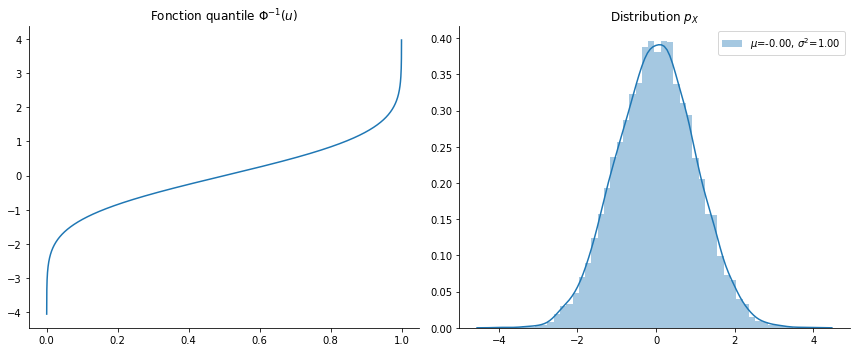

In [28]:
# information sur les données
np.random.seed(1234)
N_DATA = 10000
DATA_DIM = 1

# N_DATA tirages uniformes iid
uniform = np.random.uniform(size=(N_DATA, DATA_DIM))

# On transforme en N_DATA tirages gaussiens iid en appliquant l'inverse
# de la fct de répartition
dataset_train = stats.norm.ppf(uniform).astype(np.float32)

# La fonction viz_gaussian_train a été importée du fichier config.utils.py
# Elle permet d'obtenir l'affichage de la fonction stats.norm.ppf et de la distribution empirique
# des données, comme ci-dessous
viz_gaussian_train(uniform, dataset_train)

## Implémentation

### Generator

In [29]:
def build_generator(latent_dim, n_neurons, data_dim=DATA_DIM):
    """
    Construction du générateur
    
    Parameters
    ----------
    latent_dim: int
        Dimension de la variable latente
    n_neurons: int
        Nombre de neurones dans la couche cachée
    data_dim: int
        Dimension de l'espace des données 

    Returns
    -------
    tf.Model
        Générateur du GAN
    """    
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(n_neurons, input_shape=(latent_dim,), bias_initializer="glorot_normal"))
    
    # On utilise ici une fonction d'activation LeakyReLU : sigma(x) = ...
    # Vous pourrez tester d'autres exemples de fonction d'activation (e.g. ReLU, ou LeakyReLU avec 
    # d'autres valeurs de alpha) pour comparaison
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Dense(data_dim, bias_initializer="glorot_normal"))
    return model

G_test = build_generator(latent_dim=1, n_neurons=10)
G_test.summary()  # essayer la fonction "plot_model(G_test, show_shapes=True)"

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10)                20        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


### Discriminator

In [30]:
def build_discriminator(n_neurons, data_dim=DATA_DIM):
    """
    Construction du discriminateur
    
    Parameters
    ----------
    n_neurons: int
        Nombre de neurones dans les couches cachées
    data_dim: int
        Dimension de l'espace des données

    Returns
    -------
    tf.Model
        Discriminateur du GAN
    """
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Dense(n_neurons, input_shape=(DATA_DIM,), bias_initializer="glorot_normal", 
                           kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    ####################################################
    # A COMPLETER:
    # 1/ ajouter une deuxième couche cachée avec la meme 
    # configuration que la précédente (nombre de neurones, 
    # fct d'activation)
    
    #2/ ajouter la couche de sortie (sans fonction sigmoïde)
    model.add(layers.Dense(n_neurons, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Dense(units = 1, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    ####################################################
    return model

D_test = build_discriminator(n_neurons=10)
D_test.summary()  # essayez la fonction "plot_model(D_test, show_shapes=True)"

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 10)                20        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                110       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [31]:
def discriminator_loss(real_output, fake_output): 
    """
    Fonction de coût du discriminateur

    Parameters
    ----------
    real_output: arr
        Sorties du discriminateur D(x)
    fake_output: arr
        Sorties du générateur D(G(z))

    Returns
    -------
    float
        Moyenne des fonctions de coûts dans le batch
    """
    ##########################
    # A COMPLETER:
    # sur la base de la fonction max à optimiser
    ##########################
    return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(real_output) ) + tf.math.log(1. - tf.nn.sigmoid(fake_output) ))
  
def generator_loss(fake_output):
    """
    Fonction de coût du générateur

    Parameters
    ----------
    fake_output: arr
        Sorties du générateur D(G(z))

    Returns
    -------
    float
        Moyenne des fonctions de coûts dans le batch
    """
    ##########################
    # A COMPLETER:
    # sur la base de la fonction max à optimiser
    ##########################
    return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(fake_output) ))

### Definir la fonction d'entraînement et déterminer les paramètres

<font color ="red"> **Relancez toujours cette cellule avant de lancer la boucle d'entraînement !**

In [32]:
tf.random.set_seed(1234)
np.random.seed(1234)
counter_seed = 0

# Choix des paramètres d'entrainement:
BATCH_SIZE = 50
LATENT_DIM = 1
EPOCHS =  10
NEURONS_G = 100
NEURONS_D = 100
k = 3

# Construction du GAN
generator = build_generator(LATENT_DIM, NEURONS_G)
discriminator = build_discriminator(NEURONS_D)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# pour l'affichage
list_loss_G_train=[]
list_loss_D_train=[]

# ===========================================================================
# ===========================================================================
@tf.function
def train_step(data_batch, noise_dim):
    """
    Calcul du gradient et mise à jour des paramètres à chaque itération

    Parameters
    ----------
    data_batch: arr
        Batch de données (x_1, ..., x_m)
    noise_dim: int
        Dimension de la variable latente
    """
    
    tf.random.set_seed(counter_seed)  # actualisation de la seed pour chaque train_step 
    batch_size = data_batch.shape[0]
    
    # Entrainement du Discriminateur
    noise = tf.random.uniform([batch_size, noise_dim])  # z = (z_1, .., z_m)
    with tf.GradientTape() as disc_tape:
        generated_data = generator(noise)  # G(z)  
        real_output = discriminator(data_batch)  # D(x)
        fake_output = discriminator(generated_data)  # D(G(z))

        disc_loss = discriminator_loss(real_output, fake_output)  # calcul de la loss du discriminateur
    
    # calcul du gradient
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # mise à jour des paramètres
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        
    # Entrainement du Générateur
    #############
    # A COMPLETER
    # sur la base du discriminateur
    #############
    noise = tf.random.uniform([batch_size, noise_dim]) # z = (z_1, .., z_m)
    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise)  # G(z) 
        fake_output = discriminator(generated_data)  # D(G(z))
        
        gen_loss = generator_loss(fake_output)  # calcul de la loss du générateur
    
    # calcul du gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # mise à jour des paramètres
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return

def evaluate(data, noise_test):
    """
    Evaluation de l'erreur du générateur et du discriminateur (à utiliser pour l'affichage
    à la fin de l'entrainement)
    
    Parameters
    ----------
    data: arr
        Données de taille n, x=(x_1,..., x_n)
    noise_test: arr
        Bruit de taille n, z=(z_1,..., z_n)
        
    Returns
    -------
    loss_G: float
        valeur de la fonction de coût du générateur
    loss_D: float
        valeur de la fonction de coût du discriminateur
    """
    
    generated_data = generator(noise_test)
    real_output = discriminator(data)
    fake_output = discriminator(generated_data)
    
    loss_D = discriminator_loss(real_output, fake_output)
    loss_G = generator_loss(fake_output)

    return loss_G.numpy(), loss_D.numpy()

In [33]:
##  to examine the impact of k
def train_step_k(sub_data_batches, noise_dim, batch_size = BATCH_SIZE, k = k):
    """
    Calcul du gradient et mise à jour des paramètres à chaque itération

    Parameters
    ----------
    data_batch: arr
        Batch de données (x_1, ..., x_m)
    noise_dim: int
        Dimension de la variable latente
    """
    
    tf.random.set_seed(counter_seed)  # actualisation de la seed pour chaque train_step 
    
    # Entrainement du Discriminateur
    for i in range(k):
        data_batch = tf.convert_to_tensor(sub_data_batches[i],np.float32)  # x = (x_1, .., x_m)
        noise = tf.random.uniform([batch_size, noise_dim])  # z = (z_1, .., z_m)
        with tf.GradientTape() as disc_tape:
            generated_data = generator(noise)  # G(z)  
            real_output = discriminator(data_batch)  # D(x)
            fake_output = discriminator(generated_data)  # D(G(z))

            disc_loss = discriminator_loss(real_output, fake_output)  # calcul de la loss du discriminateur

        # calcul du gradient
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # mise à jour des paramètres
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        
    # Entrainement du Générateur
    #############
    # A COMPLETER
    # sur la base du discriminateur
    #############
    noise = tf.random.uniform([batch_size, noise_dim]) # z = (z_1, .., z_m)
    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise)  # G(z) 
        fake_output = discriminator(generated_data)  # D(G(z))
        
        gen_loss = generator_loss(fake_output)  # calcul de la loss du générateur
    
    # calcul du gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # mise à jour des paramètres
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return

**Visualisation avant entraînement**

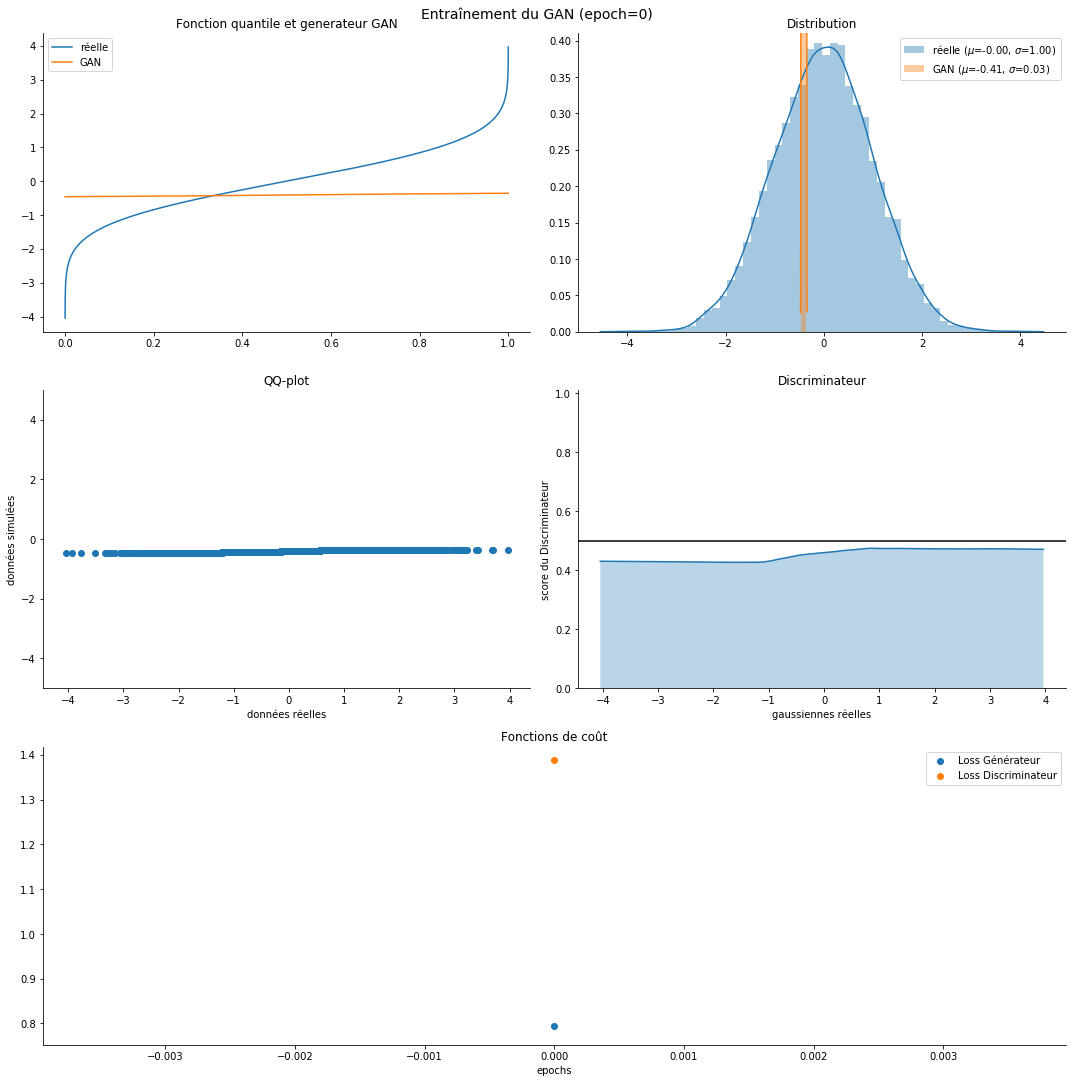

In [34]:
np.random.seed(1234)
noise_test = np.random.uniform(size=(N_DATA, LATENT_DIM))

# évaluation sur toutes les données avec un bruit test fixe
loss_G, loss_D = evaluate(dataset_train, noise_test)  
list_loss_G_train.append(loss_G)
list_loss_D_train.append(loss_D)

# Une autre fonction importée du fichier utils.py
viz_gaussian_gan(noise_test, dataset_train, generator, discriminator, list_loss_G_train, list_loss_D_train, epoch=0)

plt.savefig(os.path.join(path_dir, "imgs", "gaussian", "image_gaussian_N{}-Ldim{}-bs{}_at_epoch_{}.png".format(
    N_DATA, LATENT_DIM, BATCH_SIZE, 0)))

**Entraînement**



In [35]:
data_batches = tf.data.Dataset.from_tensor_slices(dataset_train).batch(BATCH_SIZE)
np_data_batches = np.stack(list(data_batches))

Epoch 10 (1.42 sec): Loss Generateur=1.018, Loss Discriminateur=1.068


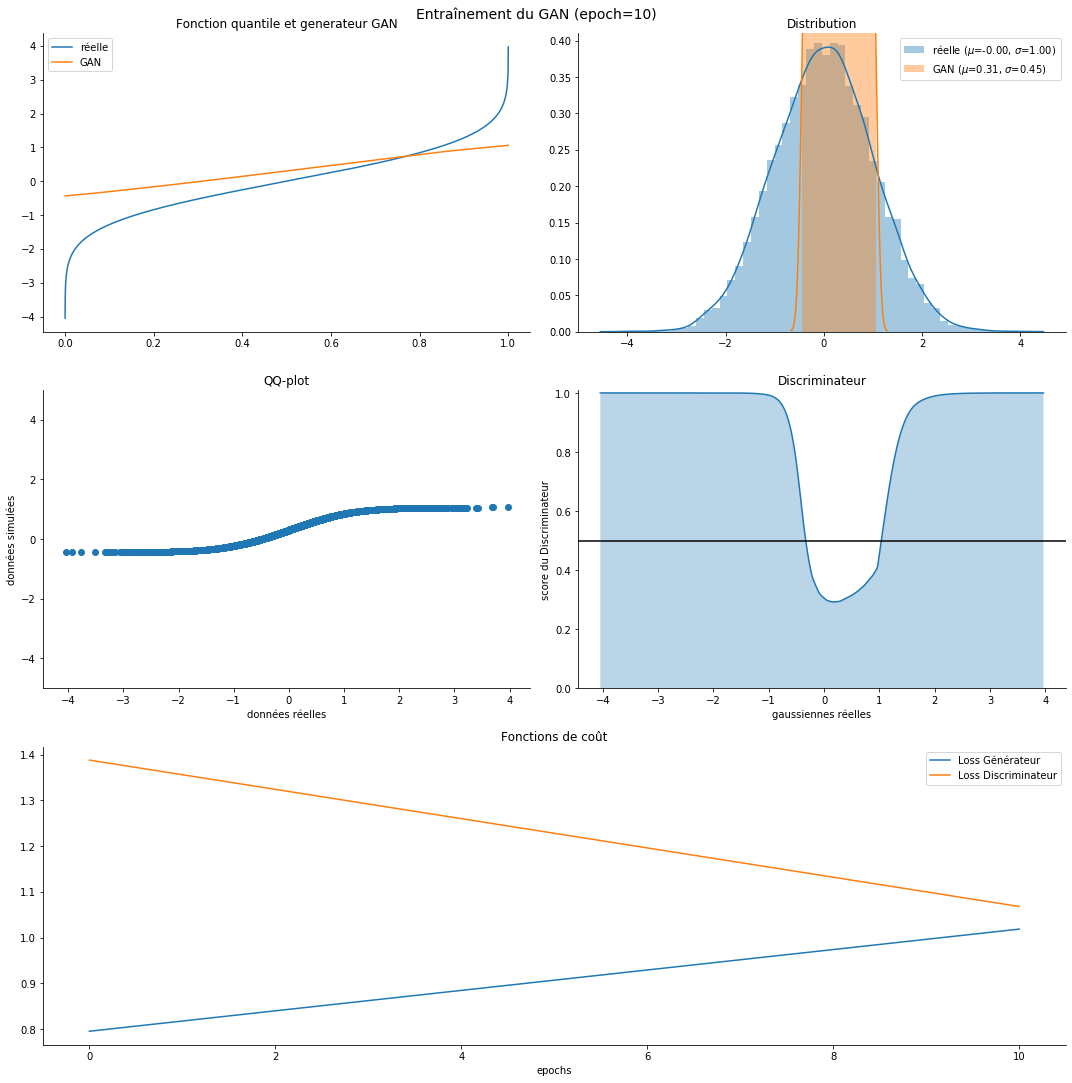

Fin de l'entraînement.


In [36]:
# Boucle d'entraînement:
print("Début de l'entraînement ...")

# division des données en batch de taille BATCH_SIZE
data_batches = tf.data.Dataset.from_tensor_slices(dataset_train).batch(BATCH_SIZE)
np_data_batches = np.stack(list(data_batches))

for epoch in range(1, EPOCHS+1):
    print("epoch = {}".format(epoch))
    start_time= time.time()
    counter_seed+=1
    
#     # mélange des données avec aléa fixé
#     data_shuffle = shuffle(dataset_train, random_state=counter_seed)
#     data_batches = tf.data.Dataset.from_tensor_slices(data_shuffle).batch(BATCH_SIZE)
    
    for i in range(int(len(data_batches)/k)):
        # print("i = {}".format(i))
        counter_seed += 1
        train_step_k(np_data_batches[(k*i):(k*i+k)], LATENT_DIM)
    
    if (epoch) % 10 == 0:    
        # évaluation à epoch modulo 10 sur toutes les données avec un bruit test fixe
        loss_G, loss_D = evaluate(dataset_train, noise_test)  
        list_loss_G_train.append(loss_G)
        list_loss_D_train.append(loss_D)
        
        time_epoch = time.time() - start_time
        display.clear_output(wait=True)
        print("Epoch {} ({:.2f} sec): Loss Generateur={:.3f}, Loss Discriminateur={:.3f}".format(\
            epoch, time_epoch, loss_G, loss_D))

        viz_gaussian_gan(noise_test, dataset_train, generator, discriminator, 
                         list_loss_G_train, list_loss_D_train, epoch)

         #sauvegarde image
        plt.savefig(os.path.join(path_dir, "imgs", "gaussian", "image_gaussian_N{}-Ldim{}-bs{}_at_epoch_{}_on_{}.png"
                                 .format(N_DATA, LATENT_DIM, BATCH_SIZE, epoch, EPOCHS)))
        plt.show()
        
    if (epoch) % (EPOCHS/10) == 0:
        # sauvegarde les modèles 10 fois durant l'entraînement
        generator.save(os.path.join(path_dir, "models", "gaussian", "generator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, EPOCHS, BATCH_SIZE)))
            
        discriminator.save(os.path.join(path_dir,"models", "gaussian", "discriminator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, EPOCHS, BATCH_SIZE)))
        
save_GIF(path_dir, N_DATA, LATENT_DIM, BATCH_SIZE, EPOCHS)   
print("Fin de l'entraînement.")

In [37]:
## perte global de GAN
def loss_GAN(data, noise, generator, discriminator):
    """
    Fonction de coût originelle du GAN

    Parameters
    ----------
    data: arr
        Données de taille n, x=(x_1,..., x_n)
    noise_test: arr
        Bruit de taille n, z=(z_1,..., z_n)
    generator: tf.Model
        générateur
    discriminator: tf.Model
        discriminateur

    Returns
    -------
    float
        fonction de coût
    """
    
    terme1 = tf.reduce_mean(tf.math.log(tf.nn.sigmoid(discriminator(data))))
    terme2 = tf.reduce_mean(tf.math.log(1. - tf.nn.sigmoid(discriminator(generator(noise_test)))))
    return terme1 + terme2

tf.random.set_seed(1234)
np.random.seed(1234)

LATENT_DIM = 1
noise_test = np.random.uniform(size=(N_DATA, LATENT_DIM))

min_global_pred = loss_GAN(dataset_train, noise_test, generator, discriminator)  # loss après entraînement

print("Dimension latente: {}".format(LATENT_DIM))
print("-"*20)
print("Minimum global du modèle après entraînement = {:.6f}".format(min_global_pred.numpy()))
print("Minimum global théorique = {:.6f}".format(-np.log(4)))

Dimension latente: 1
--------------------
Minimum global du modèle après entraînement = -1.067908
Minimum global théorique = -1.386294
